In [1]:
# Import the required packages and libs.
from single_intersection import TrafficEnv
import numpy as np
import os 
import matplotlib.pyplot as plt
import time
from sumo_rl import SumoEnvironment
import torch
# Print the sumo environment path for further verification 
print("SUMO HOME:", os.environ.get("SUMO_HOME"))
# SUMO HOME: /opt/miniconda3/lib/python3.13/site-packages/sumo

SUMO HOME: /opt/miniconda3/lib/python3.13/site-packages/sumo


In [4]:
import csv
import numpy as np
import time

def to_evaluate_agent(
        env=None,
        agent="heuristic",
        steps=1000,
        phase_duration=10,
        render=False,
        seed=42,
        to_save = None):
    """ Evaluate the performance of a method in given SUMO env."""

    # Initialization  ->  file saving 
    sim_records = []
    header = [
        "step", 
        "sim_time",
        "avg_wait_time", 
        # "total_wait_time",
        "queue_length",
        "pressure",
        "throughput",
        "avg_speed",
        "action",
        "reward"]
    
    # Initialization -> simulation loops
    obs, info = env.reset(seed=seed)
    cur_phase, phase_timer, last_arrived = 0,0,0
    done = False 

    for step in range(steps):
        if render: env.render()

        # debug 
        # print("Phase Time" , phase_timer, "Current Phase: ", cur_phase)

        #################################
        ###  Action Selection ###
        #################################
        if agent == "heuristic":
            # Determine the action
            if phase_timer >= phase_duration: # Pre-defined heuristic method
                cur_phase = (cur_phase + 1) % env.action_space.n
                phase_timer = 0
            action = cur_phase
            phase_timer += 1
        elif agent == "random": # Random Method 
            action = env.action_space.sample()
        # else: # Trained RL Agent 
        #     # action, _ 

        #################################
        ###  Feed action and observe ###
        #################################
        obs, reward, done, _, info = env.step(action)
        sim_time = env.sumo.simulation.getTime()
        # veh_ids = env.sumo.simulation.getIDList()
        # avg_wait_time = info["avg_wait_time"] # Not sure if it is available


        #######################################
        ###  Collect and store the metrics ###
        #######################################
        # wait_time_lst = []
        # queue_length = 0
        # lane_veh_counts = {}

        # for veh in veh_ids:
        #     cur_lane = env.sumo.vehicles.getLaneID(veh)
        #     cur_speed = env.sumo.vehicles.getSpeed(veh)
        #     cur_wait_time = env.sumo.vehicles.getWaitingTime(veh)

        #     if cur_speed < 0.1:
        #         queue_length += 1
        #     lane_veh_counts[cur_lane] = lane_veh_counts.get(cur_lane, 0) + 1

        #     # ====== Wait-Time ======
        #     wait_time_lst.append(cur_wait_time)
        #     # ========================

        # # Pressure
        # pressure = 0
        # for lane, count in lane_veh_counts.items():
        #     if 1:
        #         # num_incoming += count
        #         pressure += count
        #     else:
        #         num_outgoing += count
        #         pressure -= count

        # Avg wait and total wait
        # avg_wait = np.mean(wait_time_lst) if wait_time_lst else 0
        # total_wait = np.sum(wait_time_lst) if wait_time_lst else 0

        # Avg speed and total speed
        # avg_speed = np.mean(env.sumo.vehicles.getSpeed(vid) for vid in veh_ids)
        # total_speed = np.sum(env.sumo.vehicles.getSpeed(vid) for vid in veh_ids)

        # Throughput
        # total_arrived = env.sumo.simulation.getArrivedNumber()
        # throughput = total_arrived - last_arrived
        # last_arrived = total_arrived

        # Load the records into log
        sim_records.append([
            step,
            sim_time,
            info["waiting_time"],
            info["queue_length"],
            info["pressure"],
            info["throughput"],
            info["avg_speed"],
            action,
            reward])

        if done:
            obs, info = env.reset(seed=seed)
            last_arrived = 0
        
    env.close()

    if to_save:
        # supposed: results/***_evaluation_records.csv 
        folder = "results"
        os.makedirs(folder, exist_ok=True)

        save_path = os.path.join(folder, f"{to_save}_evaluation_records.csv")

        with open(save_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(header)
            writer.writerows(sim_records)
        
        print(f"Evaluation records saved to: {save_path}")

        
        return sim_records



## Heuristic baseline

In [2]:
sumo_cmd = [
    # "--start", # Uncomment this line while using the GUI for visualization 
    "--no-warnings", "true", # Uncomment this line to 
    "-n", "single-intersection.net.xml",
    "-r", "single-intersection-vertical.rou.xml",
    "--step-length", "1.0"
]

TLS_ID = "t"    

# import traci
# traci.close(False)

# Initialize SUMO environment
env = TrafficEnv(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    gui=False   # show SUMO GUI
)

logs = to_evaluate_agent(
    env=env,
    agent="heuristic",
    steps=100,
    to_save="test"
)

In [ ]:
## Define the training function

# import torch.optim as optim
# from ppo import ActorCritic, compute_gae, collect_rollout
# from torch import nn
# from helper_func import plot_traff_metrics

# Integrate into train.py



## Training Section

### Here we build the different environment first

In [ ]:
# Import the required packages and libs.
from single_intersection import TrafficEnv
from train import train_ppo
import torch.optim as optim
from ppo import ActorCritic, compute_gae, collect_rollout
from torch import nn
from helper_func import plot_traff_metrics


# SUMO command (headless for speed)
sumo_cmd = [
    # "--start", # Uncomment this line while using the GUI for visualization 
    "--no-warnings", "true", # Uncomment this line to 
    "-n", "single-intersection.net.xml",
    "-r", "single-intersection-vertical.rou.xml",
    "--step-length", "1.0"
]

TLS_ID = "t"    

# Environment with noise 
env_w_noise = TrafficEnv(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    gui=False,
    noise=True,
    noise_sigma=1.0
)

# Check if the environment is working 
obs, info = env.reset()
print(f"Environment {env.__class__.__name__} setup complete.")

# Basic Envivronment without noise (default)
env = TrafficEnv(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    gui=False   # show SUMO GUI
)

# Check if the environment is working 
obs, info = env.reset()
print(f"Environment {env.__class__.__name__} setup complete. ")



STAGE 1: Finding best reward function and noise combination (RL agent)


Stage 1 - Experiment 1: Noise=False, Reward=default
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Training RL agent...
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 735ms, vehicles TOT 0 ACT 0 BUF 0)                    
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 118ms, vehicles TOT 166 ACT 57 BUF 18)               
 Retrying in 1 seconds
Step #256.00 (1ms ~= 1000.00*RT, ~53000.00UPS, TraCI: 32ms, vehicles TOT 180 ACT 53 BUF 4)
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 30ms, vehicles TOT 184 ACT 42 BUF 0)                 
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 184 ACT 46 BUF 0)                 
 Retrying in 1 seconds
Step #256.00 (1ms ~= 1000.00*RT, ~48000.00UPS, TraCI: 30ms, vehicles TOT 184 ACT 48 BUF 0)
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 33ms, vehicles TOT 184 ACT 54 BUF 0)                 
 Retrying in 1 seconds
Step #256.00 (1ms ~= 1000.00*RT, ~35000.00UPS, TraCI: 33ms, vehicles 

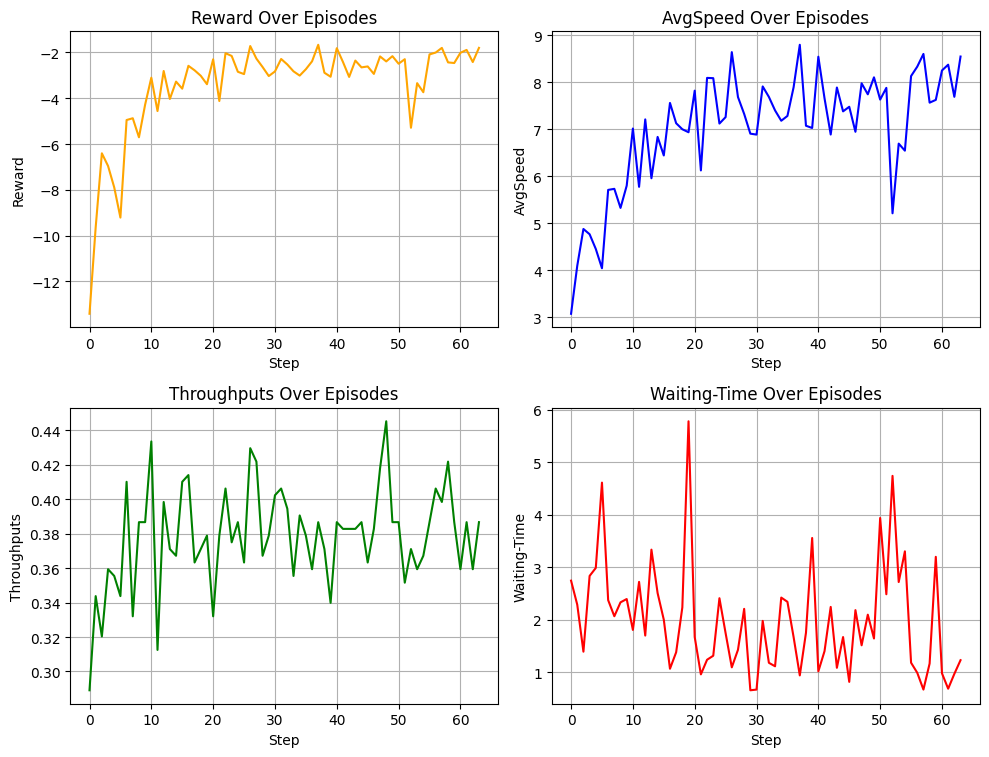

Step #256.00 (0ms ?*RT. ?UPS, TraCI: 299ms, vehicles TOT 184 ACT 23 BUF 0)                
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Evaluating RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 700 ACT 32 BUF 0)                  
Evaluation records saved to: results/stage1_exp1_rl_default_noiseFalse_evaluation_records.csv
Stage 1 - Experiment 1 completed!

Stage 1 - Experiment 2: Noise=True, Reward=default
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Training RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 40ms, vehicles TOT 170 ACT 71 BUF 14)                
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 172 ACT 54 BUF 12)                
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 32ms, vehicles TOT 180 ACT 67 BUF 4)                 
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 33ms, vehicles TOT 170 ACT 57 BUF 14)                
 Retrying in 1 seconds
Step #256.00 (1ms ~= 1000.00*RT, ~44000.00UPS, TraCI: 29ms, vehicles TOT 184 ACT 44 BUF 0)
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 184 ACT 40 BUF 0)                 
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 183 ACT 51 BU

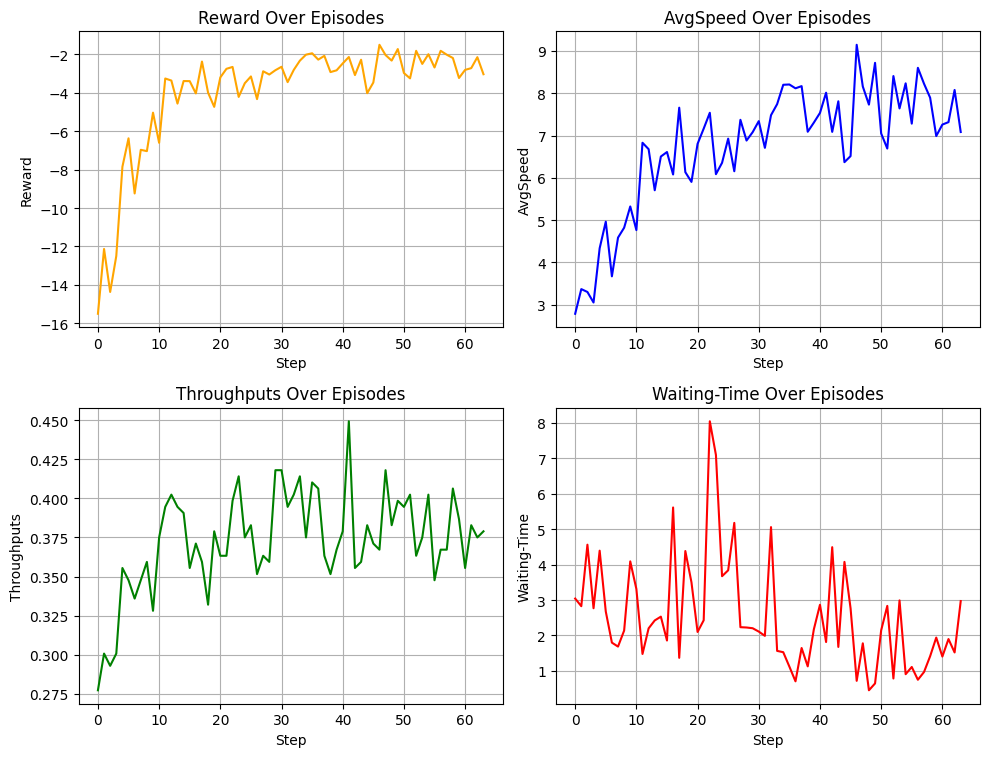

Step #256.00 (0ms ?*RT. ?UPS, TraCI: 269ms, vehicles TOT 184 ACT 27 BUF 0)                
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Evaluating RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 700 ACT 24 BUF 0)                  
Evaluation records saved to: results/stage1_exp2_rl_default_noiseTrue_evaluation_records.csv
Stage 1 - Experiment 2 completed!

STAGE 1 COMPLETE: Best configuration found!
Best metric (avg_reward): -2.8901
Best noise: True
Best reward function: default
Best reward coefficients: c1=1.0, c2=0.3, c3=0.15, c4=0.05, c5=0.005


STAGE 2: Running Heuristic and RL Agent on best configuration


Stage 2 - Experiment 3: Agent=heuristic
Configuration: Noise=True, Reward=default
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Using heuristic agent...
Evaluating heuristic agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 2ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #1000.00 (1ms ~= 1000.00*RT, ~111000.00UPS, TraCI: 24ms, vehicles TOT 482 ACT 111 BUF 
Evaluation records saved to: results/stage2_exp3_heuristic_default_noiseTrue_evaluation_records.csv
Stage 2 - Experiment 3 (heuristic) completed!

Stage 2 - Experiment 4: Agent=rl
Configuration: Noise=True, Reward=default
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Loading trained RL model from Stage 1...
Evaluating rl agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 34ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #1000.00 (1ms ~= 1000.00*RT, ~23000.00UPS, TraCI: 7ms, vehicles TOT 700 ACT 23 BUF 0) 
Evaluation records saved to: results/stage2_exp4_rl_default_noiseTrue_evaluation_records.csv
Stage 2 - Experiment 4 (rl) completed!

All experiments completed! Summary saved to: results/experiments_summary.csv
Total experiments: 4


Total experiments completed: 4
Check 'results/experiments_summary.csv' for summary of all experiments


In [4]:
# Run experiments across all combinations:
# 1. Noise v.s. Without Noise
# 2. Heuristic v.s. RL Agent
# 3. Different Reward Function 

from run_experiments import run_experiments

# SUMO command configuration
sumo_cmd = [
    "--no-warnings", "true",
    "-n", "single-intersection.net.xml",
    "-r", "single-intersection-vertical.rou.xml",
    "--step-length", "1.0"
]

TLS_ID = "t"

# Run all experiments
# This will iterate through all combinations:
# - Noise: True/False (2 options)
# - Agent: "heuristic"/"rl" (2 options)  
# - Reward configs: 4 different configurations
# Total: 2 x 2 x 4 = 16 experiments

# queue_reduction， queue_abs， pressure， switch_penalty， throughput\n",
# Reward configurations
reward_configs = [
    ("default", 1.0, 0.3, 0.15, 0.05, 0.005)
]

# Noise options
noise_options = [True, False]

# PPO training configuration
train_model_configs = {
    "LR": 3e-4,
    "N_STEPS": 256,
    "N_EPOCHS": 4,
    "MINI_BATCH_SIZE": 64,
    "TOTAL_TIMESTEPS": 4096 * 4
}


results = run_experiments(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    reward_configs=reward_configs,
    noise_options=noise_options,
    train_model_config=train_model_configs,
    eval_steps=1000,      # Evaluation steps per experiment
    # train_timesteps=4096, # Training timesteps for RL agents (only used for RL experiments)
    seed=42
)

print(f"\nTotal experiments completed: {len(results)}")
print("Check 'results/experiments_summary.csv' for summary of all experiments")



In [6]:
# model_params  = {
#     "obs_dim": env.observation_space.shape[0],
#     "act_dim": env.action_space.n
# }

# ppo_model = ActorCritic(**model_params)
# print("Model initialized. Starting training...")

# train_params = {
#     "model": ppo_model,
#     "env": env
# }

# model_hist = train_ppo(**train_params)


## RL agent and validation

## Performance Evaluation